In [11]:
import cv2
import numpy as np
import operator
import numpy as np
from grid_detection import *
import keras
from keras.models import load_model
from PIL import Image, ImageFont, ImageDraw



import matplotlib.pyplot as plt

%matplotlib inline


#reagange list in list of list for each row:
def rearange_list(nlist):
    dlist=[]
    for i in range(0, 9):
        k=9*i
        l=k+9
        sub_list=nlist[k:l]
        dlist.append(sub_list)
    return np.matrix(dlist)


#check if a value is a possible fix for an empty slot
def verify_possile_value(x, y, n, grid):
    for i in range(0, 9):
        if grid[x, i]==n:
            return False
        
    for i in range(0, 9):
        if grid[i, y]==n:
            return False
    x0=(x//3)*3
    y0=(y//3)*3
    for i in range(0, 3):
        for j in range(0, 3):
            if grid[x0+i, y0+j]==n:
                return False
            
    return True



#fill in the empty slots:
def grid_solver(grid):
    for x in range(9):
        for y in range(9):
            if grid[x, y]==0:
                for n in range(1, 10):
                    if verify_possile_value(x, y, n, grid):
                        grid[x, y]=n
                        grid_solver(grid)
                        grid[x, y]=0 #Backtracking
    return grid





       

def extract_cells_coordinates(square_img):
    cells_coodinates = np.zeros((81, 4), dtype=float)
    grid_side = square_img.shape[:1]
    cell_side = grid_side[0]/9
    k=0
    for i in range(9):
        for j in range(9):
            x1, y1 = (i * cell_side, j * cell_side) 
            x2, y2 = ((i + 1) * cell_side, (j + 1) * cell_side)
            cells_coodinates[k, :]=[x1, y1, x2, y2]
            k=k+1
    return cells_coodinates


def extract_clean_digit_area(img, coord, cell_size):
    x1, y1, x2, y2=coord
    dig=img[int(x1):int(x2), int(y1):int(y2)]
    #dig=dig[:, :, 1]
    dig=0.2989*dig[:, :, 0]+0.5870*dig[:, :, 1]+0.1140*dig[:, :, 2]
    digit=cv2.resize(dig, (cell_size, cell_size), interpolation=cv2.INTER_CUBIC)
    #digit=dig3/np.max(dig3)
    digit=np.expand_dims(digit, axis=-1)
    digit.astype('float32')
    return digit


def measure_distance(pt1, pt2):
    x = pt2[0] - pt1[0]
    y = pt2[1] - pt1[1]
    return np.sqrt((x ** 2) + (y ** 2))

        

def create_digit_img(digit, side):
    background =Image.new('RGB', (side, side), color = (255, 255, 255))
    font = ImageFont.truetype('arial.ttf', 20)
    text=str(digit)
    draw = ImageDraw.Draw(background)
    if digit>0:
        text_width, text_height = draw.textsize(text, font)
        position = ((side-text_width)/2,(side-text_height)/2)
        color=(0, 0, 0)
        draw.text(position, text, color, font=font)
    img=np.array(background)
    img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
    
    return img

def draw_lines(img, side):
    
    ll=np.shape(img)[0]
    
    for i in range(0, 10):
        
        if i in [0, 3, 6]:
            img[side*i+1, 0:ll]=0
            img[0:ll, side*i+1]=0
        elif i==9:
            img[side*i-1, 0:ll]=0
            img[0:ll, side*i-1]=0
            
        img[side*i, 0:ll]=0
        img[0:ll, side*i]=0
    return img
        

    
def create_digit_img2(digit, side, original):
    background =Image.new('RGB', (side, side), color = (255, 255, 255))
    font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 22)
    text=str(digit)
    draw = ImageDraw.Draw(background)
    #if digit>0:
    text_width, text_height = draw.textsize(text, font)
    position = ((side-text_width)/2,(side-text_height)/2)
        
    if original is True:
        color=(0, 0, 0)
            
    else:
        color=(0, 0, 255)
    
    if digit>0:
        draw.text(position, text, color, font=font)
        
    img=np.array(background)
    #img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
    
    return img

def draw_lines2(img, side):
    
    ll=np.shape(img)[0]
    
    for i in range(0, 10):
        
        if i in [0, 3, 6]:
            img[side*i+1, 0:ll, :]=(0, 0, 0)
            img[0:ll, side*i+1, :]=(0, 0, 0)
        elif i==9:
            img[side*i-1, 0:ll, :]=(0, 0, 0)
            img[0:ll, side*i-1, :]=(0, 0, 0)
            
        img[side*i, 0:ll, :]=(0, 0, 0)
        img[0:ll, side*i, :]=(0, 0, 0)
        
        
    return img

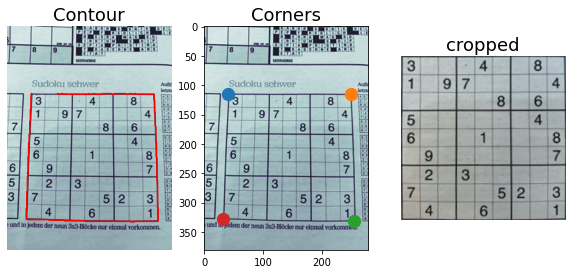

In [39]:
sudoku_img = cv2.imread('sample_img/su19.jpg')
gray = cv2.cvtColor(sudoku_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)


#new_img, contours, hier = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
aa, contours, hier = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
bigest_contour=contours[0]
polygon = bigest_contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

corners=polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]



top_left, top_right, bottom_right, bottom_left = corners



#True coordinates for img4/ su11
#top_left=[50, 10]
#top_right=[290, 25]
#bottom_left=[40,  269]

#True coordinates for img7/ su10
#top_left=[50, 38]
#top_right=[235, 42]
#bottom_right=[250, 235]

#Crop image
src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

# Get the longest side in the rectangle
side = max([
    measure_distance(bottom_right, top_right),
    measure_distance(top_left, bottom_left),
    measure_distance(bottom_right, bottom_left),
    measure_distance(top_left, top_right)
])

dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
m = cv2.getPerspectiveTransform(src, dst)

cropped=cv2.warpPerspective(sudoku_img, m, (int(side), int(side)))


#Plots:
f = plt.figure(figsize=(10,15))
f.add_subplot(1,3, 1)
plt.imshow(gray, cmap='bone')
plt.plot(bigest_contour[:, 0, 0], bigest_contour[:, 0, 1], 'r', 10)
plt.title('Contour',fontsize=18)
plt.axis('off')

f.add_subplot(1,3, 2)
for points in corners:
    plt.scatter(points[0], points[1], 150)
plt.imshow(gray, cmap='bone')
plt.title('Corners',fontsize=18)
#plt.axis('off')

f.add_subplot(1,3, 3)
plt.imshow(cropped)
plt.title('cropped',fontsize=18)
plt.axis('off')
#plt.savefig('grid_detection.png', bbox_inches='tight')

plt.show()


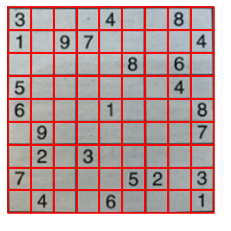

In [40]:
cells_coor=extract_cells_coordinates(cropped)
#np.shape(cells_coor)[0]
plt.imshow(cropped, cmap='bone')  
for i in range(0, np.shape(cells_coor)[0]):
    x1, y1, x2, y2=cells_coor[i, :]
    x=[x1, x2, x2, x1, x1]
    y=[y1, y1, y2, y2, y1]
    plt.plot(x, y, 'r')
plt.axis('off')
#plt.savefig('grid.png', bbox_inches='tight')
plt.show()  

In [5]:
np.shape(cropped)

(314, 314, 3)

In [41]:
total_dig=np.zeros((81, 45, 45, 1), dtype=float)#raw images
for i in range(0, np.shape(cells_coor)[0]):
    digit=extract_clean_digit_area(cropped, cells_coor[i, :], 45)
    total_dig[i, :, :, :]=digit
    
total_dig=total_dig-np.min(total_dig)
total_dig=total_dig/np.max(total_dig)

In [42]:

model_path='train_digit_model/digit_recognition_model.h5'
model = load_model(model_path)
pred=model.predict(total_dig)

In [43]:
list_values=list(pred.argmax(1))
matrix_cell=rearange_list(list_values)
print(matrix_cell)

[[3 0 0 0 4 0 0 8 0]
 [1 0 9 7 0 0 0 0 4]
 [0 0 0 0 0 8 0 6 0]
 [5 0 0 0 0 0 0 4 0]
 [6 0 0 0 1 0 0 0 8]
 [0 9 0 0 0 0 0 0 7]
 [0 2 0 3 0 0 0 0 0]
 [7 0 0 0 0 5 2 0 3]
 [0 4 0 0 6 0 0 0 1]]


In [44]:
print(list_values)

[3, 0, 0, 0, 4, 0, 0, 8, 0, 1, 0, 9, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 8, 0, 6, 0, 5, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 1, 0, 0, 0, 8, 0, 9, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0, 3, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 5, 2, 0, 3, 0, 4, 0, 0, 6, 0, 0, 0, 1]


In [45]:
side=30 #Size of one cell

backgr=np.ones((9*side+1, 9*side+1, 3))*255
backgr=backgr.astype(np.uint8)
#put digits:
for i in range(0, 9):
    for j in range(0, 9):
        original=True
        digit=matrix_cell[i, j]
        img=create_digit_img2(digit, side, original)
        backgr[i*side:(i+1)*side, j*side:(j+1)*side, :]=img


backgr=draw_lines2(backgr, side)
backgr=backgr.astype(np.uint8)

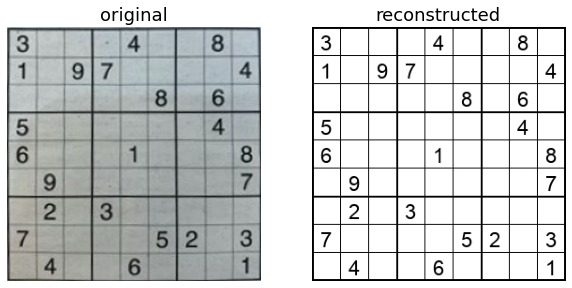

In [46]:
f = plt.figure(figsize=(10,20))
f.add_subplot(1,2, 1)
plt.imshow(cropped, cmap='bone')

plt.title('original',fontsize=18)
plt.axis('off')

f.add_subplot(1,2, 2)
plt.imshow(backgr, cmap='bone')
plt.title('reconstructed',fontsize=18)
plt.axis('off')
plt.show()


In [47]:
#y=[2, 1, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 1, 3, 0, 8, 0, 4, 0, 3, 0, 0, 0, 0, 0, 5, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0, 4, 3, 9, 0, 0, 7, 0, 8, 0, 6, 0, 0, 0, 4, 0, 8, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 8, 6, 1, 5, 0, 0, 0, 0, 0, 0, 0]
y=list_values

#y=np.load('data_npy/list_label14.npy')
print(list_values)
matrix_cell2=rearange_list(y)
print(matrix_cell2)

[3, 0, 0, 0, 4, 0, 0, 8, 0, 1, 0, 9, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 8, 0, 6, 0, 5, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 1, 0, 0, 0, 8, 0, 9, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0, 3, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 5, 2, 0, 3, 0, 4, 0, 0, 6, 0, 0, 0, 1]
[[3 0 0 0 4 0 0 8 0]
 [1 0 9 7 0 0 0 0 4]
 [0 0 0 0 0 8 0 6 0]
 [5 0 0 0 0 0 0 4 0]
 [6 0 0 0 1 0 0 0 8]
 [0 9 0 0 0 0 0 0 7]
 [0 2 0 3 0 0 0 0 0]
 [7 0 0 0 0 5 2 0 3]
 [0 4 0 0 6 0 0 0 1]]


In [48]:
np.save('data_npy/unfiltered_im19.npy', total_dig)
np.save('data_npy/list_label19.npy', y)

In [16]:

for i in range(1, 17):
    path_x='data_npy/unfiltered_im'+str(i)+'.npy'
    path_y='data_npy/list_label'+str(i)+'.npy'
    
    x=np.load(path_x)
    y=np.load(path_y)
    if i==1:
        xx=x
        yy=y
    else:
        yy=np.append(yy, y)
        xx=np.append(xx, x, axis=0)
        

In [17]:
print(len(yy))

1296


In [18]:
np.shape(xx)
np.save('data_npy/tot_img16.npy',xx)
np.save('data_npy/tot_labels16.npy', yy)

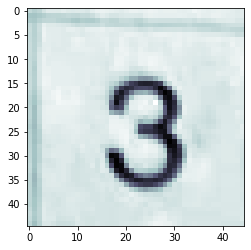

In [165]:
img_test=total_dig[10, :, :, 0]

plt.imshow(img_test, cmap='bone')
plt.show()

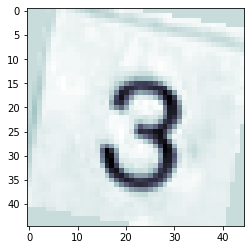

In [169]:
from scipy import ndimage, misc
img_45 = ndimage.rotate(img_test, -10, reshape=False, cval=0.8)

plt.imshow(img_45, cmap='bone')
plt.show()
#cval=np.random.uniform(0.5, 1)